# Подключение бибилиотек


In [ ]:
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization 
from tensorflow.keras import backend as K 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import utils 
from google.colab import files
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing import image 
import numpy as np 
from sklearn.model_selection import train_test_split
import time
import random
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from PIL import Image 

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dir_image = '/content/drive/MyDrive/DF/Black Sea Sprat/Black Sea Sprat'
dir_mask = '/content/drive/MyDrive/DF/Black Sea Sprat/Black Sea Sprat GT'

In [ ]:
trainImg = []

for filename in sorted(os.listdir(dir_image)):
    trainImg.append(img_to_array(load_img(os.path.join(dir_image, filename), target_size=(128, 240))).astype('uint8'))

In [ ]:
trainMask = []

for filename in sorted(os.listdir(dir_mask)):
    trainMask.append(img_to_array(load_img(os.path.join(dir_mask, filename), target_size=(128, 240))).astype('uint8'))

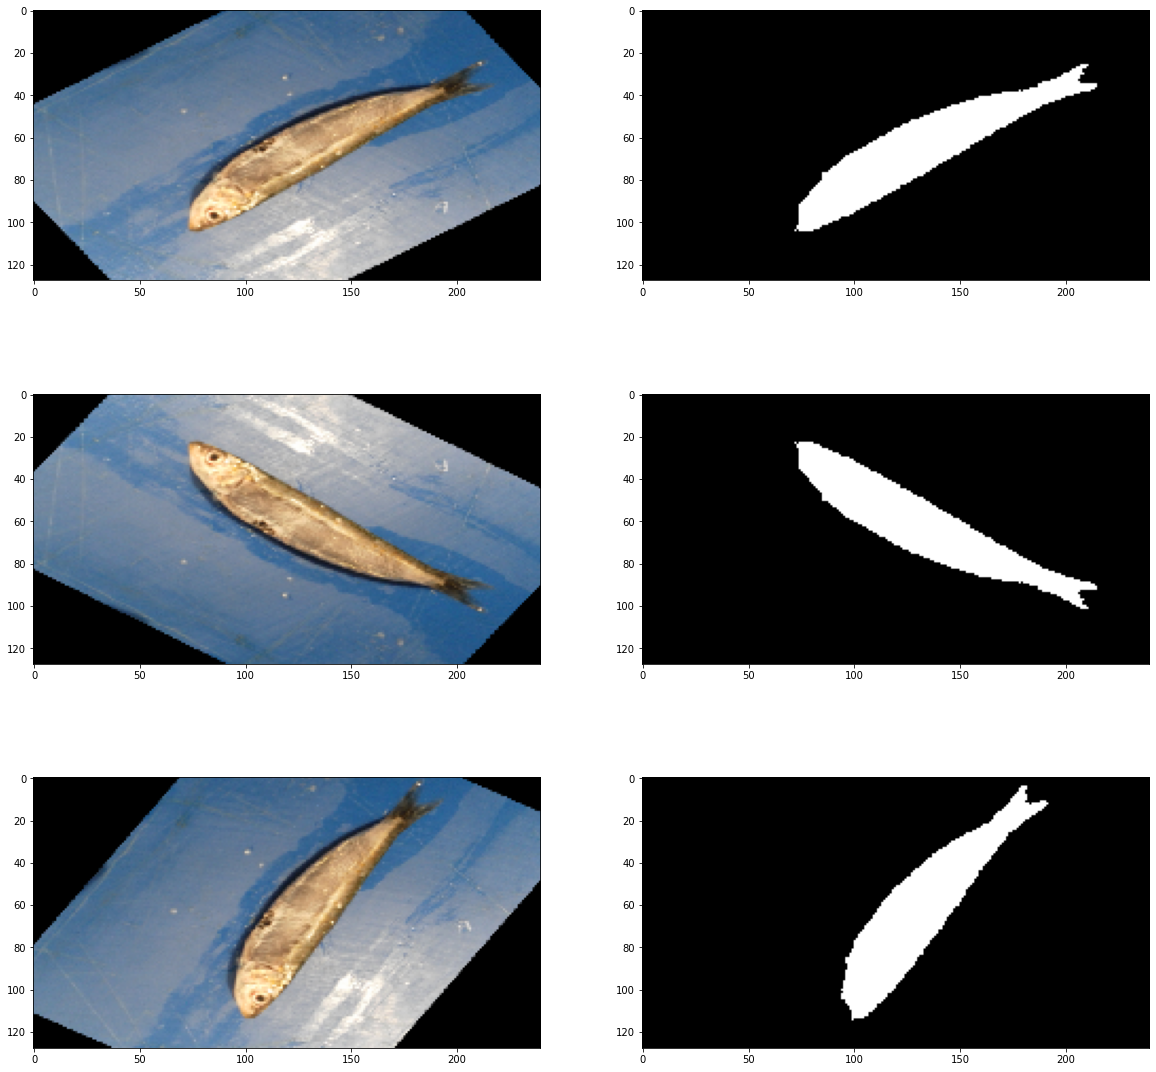

In [ ]:
fig, axs = plt.subplots(3, 2)
fig.set_figheight(20)
fig.set_figwidth(20)

for i in range(3):
  axs[i][0].imshow(trainImg[i])
  axs[i][1].imshow(trainMask[i])  

In [ ]:
trainImg = np.array(trainImg) / 255
trainMask = np.array(trainMask)[:, :, :, 0]/ 255

In [ ]:
trainMask.shape

(1000, 256, 480)

In [ ]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unet(num_classes = 1, input_shape= (88, 120, 3)):
    img_input = Input(input_shape)                                         

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) 
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         
    x = BatchNormalization()(x)                                            
    block_1_out = Activation('relu')(x)                                    

    x = MaxPooling2D()(block_1_out)                                        

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        
    x = BatchNormalization()(x)                                            
    block_2_out = Activation('relu')(x)                                    

    x = MaxPooling2D()(block_2_out)                                        

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        
    x = BatchNormalization()(x)                                            
    block_3_out = Activation('relu')(x)                                    

    x = MaxPooling2D()(block_3_out)                                        

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        
    x = BatchNormalization()(x)                                            
    block_4_out = Activation('relu')(x)                                    
    x = block_4_out 

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = concatenate([x, block_3_out])                                      
    x = Conv2D(256, (3, 3), padding='same')(x)                             
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                           
    x = Activation('relu')(x)                 

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)  
    x = BatchNormalization()(x) 
    x = Activation('relu')(x) 

    x = concatenate([x, block_2_out])                                    
    x = Conv2D(128, (3, 3), padding='same')(x)                      
    x = BatchNormalization()(x)                                           
    x = Activation('relu')(x)                                              

    x = Conv2D(128, (3, 3), padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x) 

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x) 

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x) 

    x = Conv2D(64, (3, 3), padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x) 

    x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)  

    model = Model(img_input, x) 

 
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=[dice_coef])
    
    return model 

In [ ]:
model = unet(1, trainImg[0].shape)
history = model.fit(trainImg[:800], trainMask[:800], epochs=30, batch_size=16, validation_data = (trainImg[800:], trainMask[800:]))

Epoch 1/30
50/50 [==============================] - 57s 852ms/step - loss: 0.1207 - dice_coef: 0.7369 - val_loss: 0.3425 - val_dice_coef: 0.1099
Epoch 2/30
50/50 [==============================] - 40s 793ms/step - loss: 0.0286 - dice_coef: 0.9020 - val_loss: 0.4484 - val_dice_coef: 0.0399
Epoch 3/30
50/50 [==============================] - 40s 793ms/step - loss: 0.0219 - dice_coef: 0.9251 - val_loss: 0.5814 - val_dice_coef: 0.0128
Epoch 4/30
50/50 [==============================] - 39s 791ms/step - loss: 0.0188 - dice_coef: 0.9360 - val_loss: 0.6747 - val_dice_coef: 0.0068
Epoch 5/30
50/50 [==============================] - 39s 791ms/step - loss: 0.0175 - dice_coef: 0.9416 - val_loss: 0.7698 - val_dice_coef: 0.0032
Epoch 6/30
50/50 [==============================] - 40s 792ms/step - loss: 0.0174 - dice_coef: 0.9428 - val_loss: 0.8179 - val_dice_coef: 0.0018
Epoch 7/30
50/50 [==============================] - 39s 791ms/step - loss: 0.0151 - dice_coef: 0.9492 - val_loss: 0.8346 - val_dic

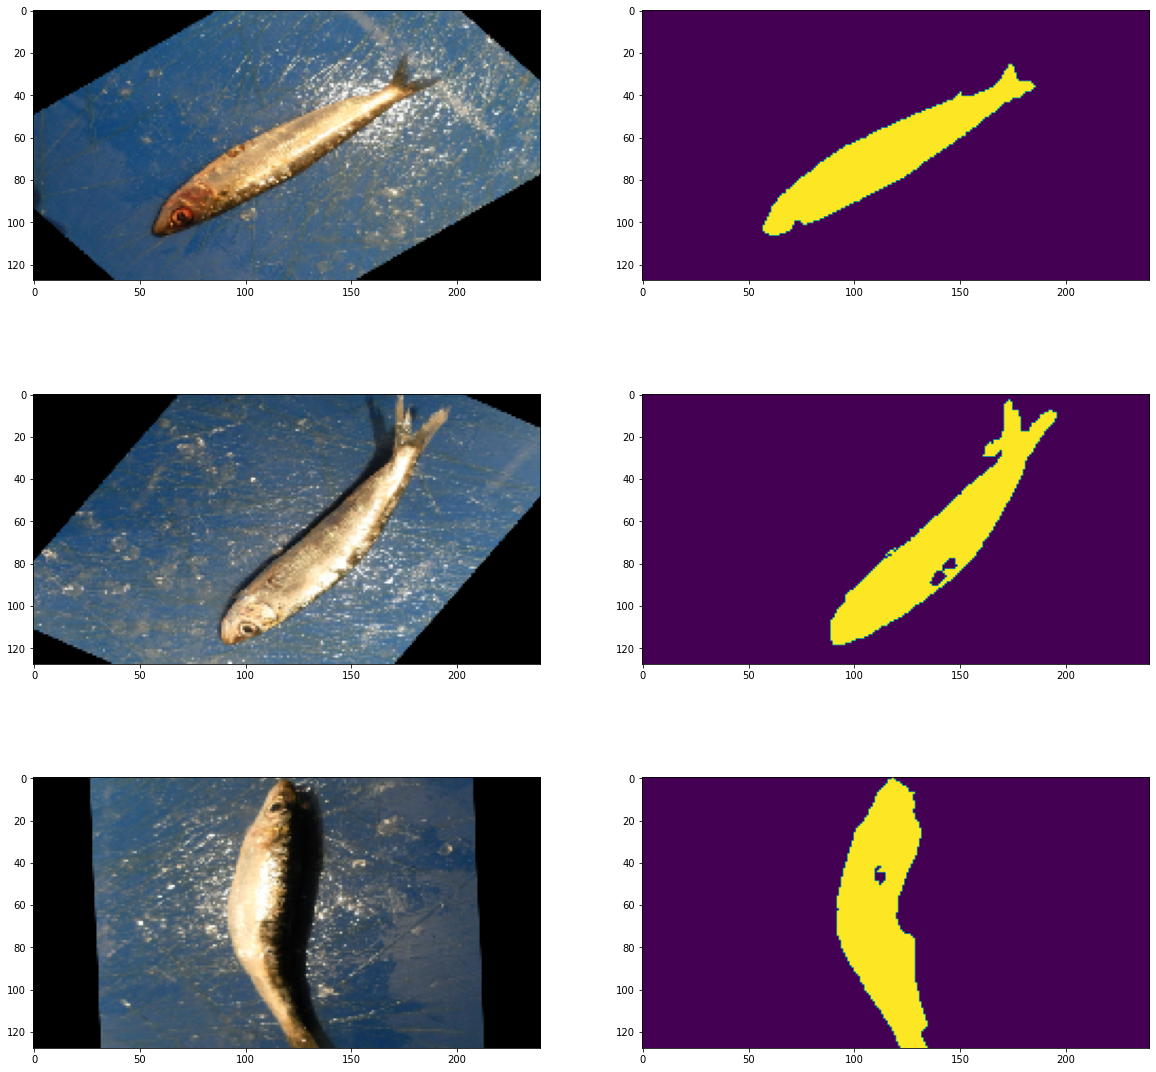

In [ ]:
fig, axs = plt.subplots(3, 2)
fig.set_figheight(20)
fig.set_figwidth(20)

for i in range(3):
  numb=np.random.randint(800,1000)
  axs[i][0].imshow(trainImg[numb])
  axs[i][1].imshow(model.predict(np.expand_dims(trainImg[numb], axis=0)).reshape(128,240)>0.5)